<a href="https://colab.research.google.com/github/Skichok/Doomoncalcprjctn1/blob/main/%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B4%D0%BE_2023_10_23_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22Segmentation_HW_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашняя работа 1

Вам предстоит решить две задачи.

1. Задача бинарной классификации изображений на кошек и собак.
Вам дан датасет, который нужно скачать. В датасете уже сделано разбиение на тренировочную, тестовую и валидационную части. Вам необходимо самостоятельно реализовать пайплайн обучения нейронной сети для бинарной классификации. Обучайтесь на тренировочной части, во время обучения проверяйте качество на тестовой выборке. С помощью функции test_model оцените точность вашей нейронной сети на тестовой и валидационной выборке. Задача считается решенной при точности >80% на валидационной выборке, за точность 92% и выше на валидации будут поставлены доп баллы.

2. Задача сегментации. К этой задаче приложены типовые решения с помощью свёрточных нейронных сетей. Однако с предложенной архитектурой не всё в порядке и вам предстоит диагностировать проблему и стабилизировать тренировку вашей сети.

# Задача 1 (0.4 балла)

#  1 ПОДГОТОВКА И РАЗВЕДОЧНЫЙ АНАЛИЗ ДАННЫХ

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive -l



total 4
drwx------ 25 root root 4096 Oct 21 14:41 MyDrive


In [ ]:
### Let's have a cell with global hyperparameters for the CNNs in this notebook

# Path to a directory with image dataset and subfolders for training, validation and final testing
DATA_PATH='/content/data'

# Number of threads for data loader
NUM_WORKERS = 2

# Image size: even though image sizes are bigger than 96, we use this to speed up training
SIZE_H = SIZE_W = 96
N_CHANNELS = 3

# Number of classes in the dataset
NUM_CLASSES = 2

# Epochs: number of passes over the training data, we use it this small to reduce training babysitting time
EPOCH_NUM = 30

# Batch size: for batch gradient descent optimization, usually selected as 2**K elements
BATCH_SIZE = 128

# Images mean and std channelwise
image_mean = [0.485, 0.456, 0.406]
image_std = [0.229, 0.224, 0.225]

# Last layer (embeddings) size for CNN models
EMBEDDING_SIZE = 256

In [ ]:
#импортируем все необходимые библиотеки
import os
import time

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from matplotlib import pyplot as plt
from torchsummary import summary
from torchvision import transforms
from tqdm import tqdm_notebook as tqdm

In [ ]:
!wget -nc https://www.dropbox.com/s/gqdo90vhli893e0/data.zip
!unzip -n data.zip -d data

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: data/train_11k/dog/dog.11174.jpg  
  inflating: data/train_11k/dog/dog.11175.jpg  
  inflating: data/train_11k/dog/dog.11177.jpg  
  inflating: data/train_11k/dog/dog.11180.jpg  
  inflating: data/train_11k/dog/dog.11182.jpg  
  inflating: data/train_11k/dog/dog.11183.jpg  
  inflating: data/train_11k/dog/dog.11185.jpg  
  inflating: data/train_11k/dog/dog.11189.jpg  
  inflating: data/train_11k/dog/dog.1119.jpg  
  inflating: data/train_11k/dog/dog.11190.jpg  
  inflating: data/train_11k/dog/dog.11193.jpg  
  inflating: data/train_11k/dog/dog.11194.jpg  
  inflating: data/train_11k/dog/dog.11196.jpg  
  inflating: data/train_11k/dog/dog.11197.jpg  
  inflating: data/train_11k/dog/dog.11198.jpg  
  inflating: data/train_11k/dog/dog.1120.jpg  
  inflating: data/train_11k/dog/dog.11201.jpg  
  inflating: data/train_11k/dog/dog.11202.jpg  
  inflating: data/train_11k/dog/dog.11204.jpg  
  inflating: data/trai

In [ ]:
import glob

glob.glob("data/*")

['data/val', 'data/train_11k', 'data/test_labeled']

In [ ]:
data_batch, label_batch = next(iter(train_dataset))

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [ ]:
!ls data

test_labeled  train_11k  val


In [ ]:
transformer = transforms.Compose(
    [
        transforms.Resize((SIZE_H, SIZE_W)),  # scaling images to fixed size
        transforms.ToTensor(),  # converting to tensors
        transforms.Normalize(image_mean, image_std),  # normalize image data per-channel
    ]
)
#transformer = None

In [ ]:
train_dataset = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'train_11k'), transform=transformer)
val_dataset   = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'val'), transform=transformer)
test_dataset  = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'test_labeled'), transform=transformer)

In [ ]:
def mk_data_loader(*ds):
   return tuple(map(lambda x: torch.utils.data.DataLoader(
    x,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    # worker_init_fn=worker_init_fn
      ) ,ds))



In [ ]:
train_loader,val_loader,test_loader =mk_data_loader (train_dataset, val_dataset,test_dataset)

In [ ]:
def plot_from_loader(loader):
    data_batch, label_batch = next(iter(loader))
    grid_size = (3, 3)
    f, axarr = plt.subplots(*grid_size)
    f.set_size_inches(15, 10)
    class_names = loader.dataset.classes
    for i in range(grid_size[0] * grid_size[1]):
        # read images from batch to numpy.ndarray and change axes order [H, W, C] -> [H, W, C]
        batch_image_ndarray = np.transpose(data_batch[i].numpy(), [1, 2, 0])

        # inverse normalization for image data values back to [0,1] and clipping the values for correct pyplot.imshow()
        src = np.clip(image_std * batch_image_ndarray + image_mean, 0, 1)

        # display batch samples with labels
        sample_title = "Label = %d (%s)" % (label_batch[i], class_names[label_batch[i]])
        axarr[i // grid_size[0], i % grid_size[0]].imshow(src)
        axarr[i // grid_size[0], i % grid_size[0]].set_title(sample_title)

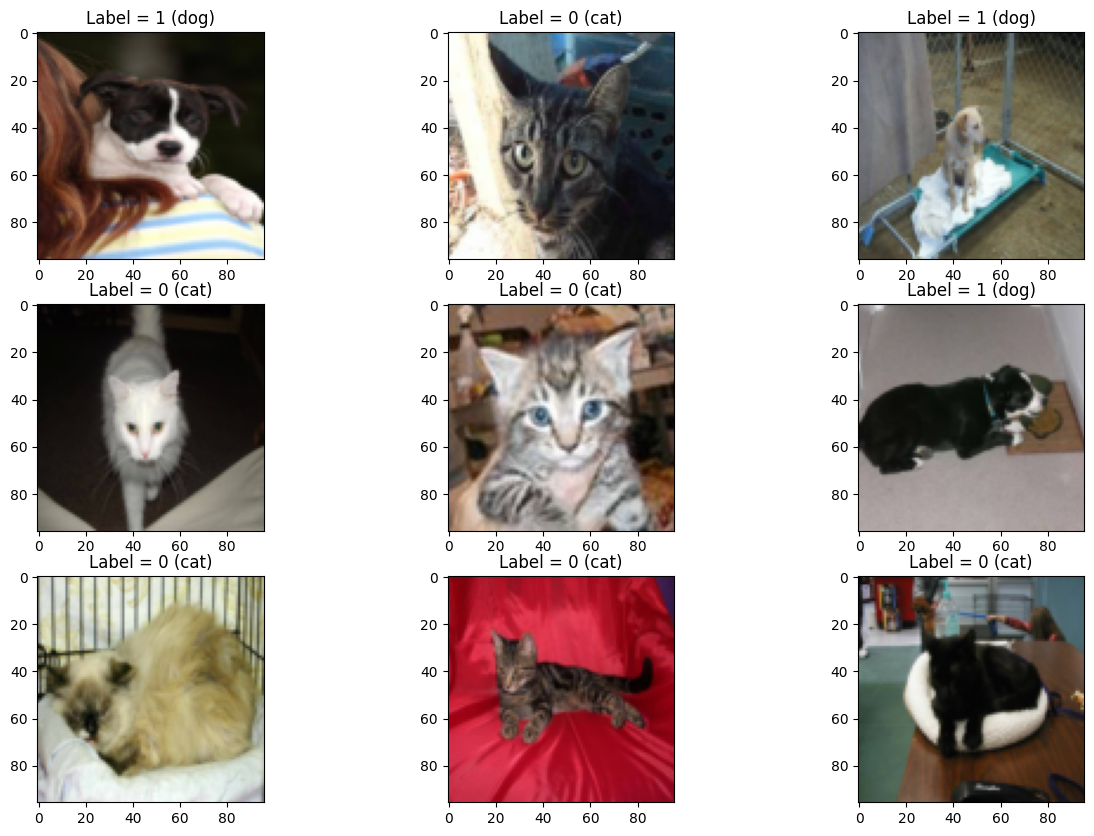

In [ ]:
plot_from_loader(val_loader)

2 МОДЕЛЬ И ОБУЧЕНИЕ


In [ ]:
n_train, n_val, n_test = len(train_dataset), len(val_dataset), len(test_dataset)

In [ ]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs):
    """
    model: нейросеть для обучения,
    train_loader, val_loader: загрузчики данных
    loss_fn: целевая метрика (которую будем оптимизировать)
    opt: оптимизатор (обновляет веса нейросети)
    n_epochs: кол-во эпох, полных проходов датасета
    """
    train_loss = []
    val_accuracy = []

    for epoch in range(n_epochs):
        start_time = time.time()

        model.train(True)  # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            opt.zero_grad()
            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch)
            loss.backward()
            #             torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            opt.step()
            train_loss.append(loss.item())

        model.train(False)  # disable dropout / use averages for batch_norm
        for X_batch, y_batch in val_loader:
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # compute logits
            logits = model(X_batch)
            y_pred = logits.max(1)[1].data
            val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))

        # print the results for this epoch:
        print(f"Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s")

        train_loss_value = np.mean(train_loss[-n_train // BATCH_SIZE :])
        val_accuracy_value = np.mean(val_accuracy[-n_val // BATCH_SIZE :]) * 100

        print(f"  training loss (in-iteration): \t{train_loss_value:.6f}")
        print(f"  validation accuracy: \t\t\t{val_accuracy_value:.2f} %")

    return train_loss, val_accuracy

In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [ ]:
p = 0.3
model_cnn = nn.Sequential()

model_cnn.add_module("first_batch_norm_layer", nn.BatchNorm2d(3))
model_cnn.add_module(
    "first_conv_layer",
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
)
model_cnn.add_module(
    "first_pool_layer", nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)  # 96 -> 48
model_cnn.add_module("first_activation", nn.ReLU())
model_cnn.add_module("first_dropout", nn.Dropout2d(p))
model_cnn.add_module("second_batch_norm_layer", nn.BatchNorm2d(32))
model_cnn.add_module(
    "second_conv_layer",
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
)
model_cnn.add_module(
    "second_pool_layer", nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)  # 48 -> 24
model_cnn.add_module("second_activation", nn.ReLU())
model_cnn.add_module("second_dropout", nn.Dropout2d(p))
model_cnn.add_module("third_batch_norm_layer", nn.BatchNorm2d(64))
model_cnn.add_module(
    "third_conv_layer",
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
)
model_cnn.add_module(
    "third_pool_layer", nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)  # 24 -> 12
model_cnn.add_module("third_activation", nn.ReLU())
model_cnn.add_module("third_dropout", nn.Dropout2d(p))
model_cnn.add_module("fourth_batch_norm_layer", nn.BatchNorm2d(128))
model_cnn.add_module(
    "fourth_conv_layer",
    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
)
model_cnn.add_module(
    "fourth_pool_layer", nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)  # 12 -> 6
model_cnn.add_module("fourth_activation", nn.ReLU())
model_cnn.add_module("fourth_dropout", nn.Dropout2d(p))
model_cnn.add_module("flatten", Flatten())
model_cnn.add_module("linear_batch_norm_layer", nn.BatchNorm1d(6 * 6 * 128))
model_cnn.add_module("linear", nn.Linear(6 * 6 * 128, EMBEDDING_SIZE))
model_cnn.add_module("fourth_activation", nn.ReLU())
model_cnn.add_module("fourth_dropout", nn.Dropout(p))
model_cnn.add_module("logits_batch_norm_layer", nn.BatchNorm1d(EMBEDDING_SIZE))
model_cnn.add_module("logits", nn.Linear(EMBEDDING_SIZE, NUM_CLASSES))
model_cnn.add_module("prdiction", nn.Sigmoid())

model_cnn = model_cnn.to(device)

In [ ]:
summary(model_cnn, (N_CHANNELS, SIZE_H, SIZE_W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 96, 96]               6
            Conv2d-2           [-1, 32, 96, 96]             896
         MaxPool2d-3           [-1, 32, 48, 48]               0
              ReLU-4           [-1, 32, 48, 48]               0
         Dropout2d-5           [-1, 32, 48, 48]               0
       BatchNorm2d-6           [-1, 32, 48, 48]              64
            Conv2d-7           [-1, 64, 48, 48]          18,496
         MaxPool2d-8           [-1, 64, 24, 24]               0
              ReLU-9           [-1, 64, 24, 24]               0
        Dropout2d-10           [-1, 64, 24, 24]               0
      BatchNorm2d-11           [-1, 64, 24, 24]             128
           Conv2d-12          [-1, 128, 24, 24]          73,856
        MaxPool2d-13          [-1, 128, 12, 12]               0
             ReLU-14          [-1, 128,

In [ ]:
opt = torch.optim.Adam(model_cnn.parameters(), lr=3e-4, weight_decay=1e-5)

loss_fn = nn.CrossEntropyLoss()

train_loss, val_accuracy = train_model(
    model_cnn, train_loader, val_loader, loss_fn, opt, 125
)

Epoch 1 of 125 took 36.232s
  training loss (in-iteration): 	0.601612
  validation accuracy: 			65.10 %
Epoch 2 of 125 took 37.534s
  training loss (in-iteration): 	0.573317
  validation accuracy: 			69.87 %
Epoch 3 of 125 took 37.718s
  training loss (in-iteration): 	0.559323
  validation accuracy: 			67.39 %
Epoch 4 of 125 took 36.558s
  training loss (in-iteration): 	0.547496
  validation accuracy: 			70.89 %
Epoch 5 of 125 took 37.410s
  training loss (in-iteration): 	0.541291
  validation accuracy: 			74.22 %
Epoch 6 of 125 took 35.487s
  training loss (in-iteration): 	0.534366
  validation accuracy: 			72.96 %
Epoch 7 of 125 took 37.516s
  training loss (in-iteration): 	0.523013
  validation accuracy: 			74.15 %
Epoch 8 of 125 took 35.963s
  training loss (in-iteration): 	0.515454
  validation accuracy: 			75.87 %
Epoch 9 of 125 took 37.744s
  training loss (in-iteration): 	0.511732
  validation accuracy: 			75.85 %
Epoch 10 of 125 took 35.470s
  training loss (in-iteration): 	0.

KeyboardInterrupt: ignored

In [ ]:
!ls drive/MyDrive/ML_DISK

In [ ]:
torch.save(model_cnn, 'drive/MyDrive/ML_DISK/model.sav')

3. ТЕСТИРОВАНИЕ МОДЕЛИ

In [ ]:
model_test = torch.load('drive/MyDrive/ML_DISK/model.sav')


In [ ]:
summary(model_test, (N_CHANNELS, SIZE_H, SIZE_W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 96, 96]               6
            Conv2d-2           [-1, 32, 96, 96]             896
         MaxPool2d-3           [-1, 32, 48, 48]               0
              ReLU-4           [-1, 32, 48, 48]               0
         Dropout2d-5           [-1, 32, 48, 48]               0
       BatchNorm2d-6           [-1, 32, 48, 48]              64
            Conv2d-7           [-1, 64, 48, 48]          18,496
         MaxPool2d-8           [-1, 64, 24, 24]               0
              ReLU-9           [-1, 64, 24, 24]               0
        Dropout2d-10           [-1, 64, 24, 24]               0
      BatchNorm2d-11           [-1, 64, 24, 24]             128
           Conv2d-12          [-1, 128, 24, 24]          73,856
        MaxPool2d-13          [-1, 128, 12, 12]               0
             ReLU-14          [-1, 128,

In [ ]:
def test_model(model, test_loader, subset='test'):
    model.train(False) # disable dropout / use averages for batch_norm
    test_batch_acc = []
    for X_batch, y_batch in test_loader:
        logits = model(X_batch.to(device))
        y_pred = logits.max(1)[1].data
        test_batch_acc.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))

    test_accuracy = np.mean(test_batch_acc)

    print("Results:")
    print(f"  {subset} accuracy:\t\t{test_accuracy * 100:.2f} %")
    if test_accuracy > 0.92:
        print("Amazing!")
    elif test_accuracy > 0.8:
        print("Good!")
    else:
        print("Need more magic!")
    return test_accuracy

In [ ]:
best_model = model_test

val_accuracy = test_model(best_model, val_loader, subset='val')
test_accuracy = test_model(best_model, test_loader, subset='test')

Results:
  val accuracy:		82.32 %
Good!
Results:
  test accuracy:		83.12 %
Good!


#Задача 2 (0.6 балла)

In [ ]:
# Библиотека для сегментации
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=23cade1b2caefb83b7da6dee15c344ae23d6fa4990b17adae923601e9836b0f3
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60943 sha256=d2e4fb6e0f23e39a6331484e8e8302c014edbc1ed4ec4203f6647b6df2d90076
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

from pprint import pprint
from torch.utils.data import DataLoader

Работа будет вестись с датасетом SimpleOxfordPetDataset

Следующий блок обучающий и содержит в себе информацию о способе решения задачи сегментации

In [ ]:
from segmentation_models_pytorch.datasets import SimpleOxfordPetDataset

In [ ]:
# download data
root = "."
SimpleOxfordPetDataset.download(root)

images.tar.gz: 100%|██████████| 755M/755M [00:35<00:00, 22.6MB/s]
annotations.tar.gz: 100%|██████████| 18.3M/18.3M [00:04<00:00, 4.73MB/s]


In [ ]:
# init train, val, test sets
train_dataset = SimpleOxfordPetDataset(root, "train")
valid_dataset = SimpleOxfordPetDataset(root, "valid")
test_dataset = SimpleOxfordPetDataset(root, "test")

# It is a good practice to check datasets don`t intersects with each other
assert set(test_dataset.filenames).isdisjoint(set(train_dataset.filenames))
assert set(test_dataset.filenames).isdisjoint(set(valid_dataset.filenames))
assert set(train_dataset.filenames).isdisjoint(set(valid_dataset.filenames))

print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(valid_dataset)}")
print(f"Test size: {len(test_dataset)}")

n_cpu = os.cpu_count()
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=n_cpu)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=n_cpu)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=n_cpu)

Train size: 3312
Valid size: 368
Test size: 3669


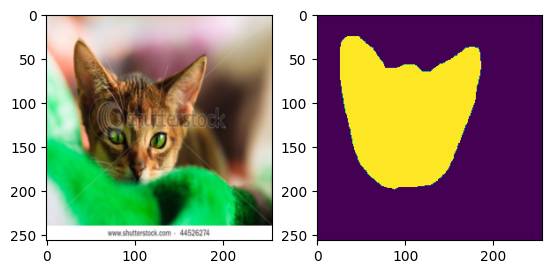

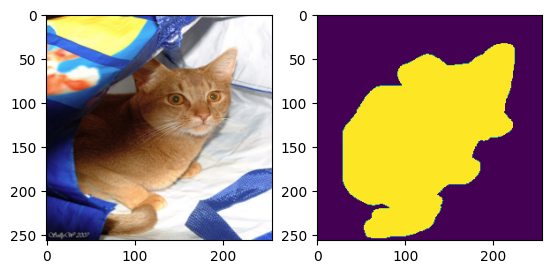

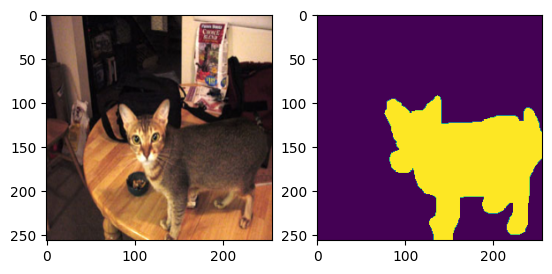

In [ ]:
# lets look at some samples

sample = train_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

sample = valid_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

sample = test_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

In [ ]:
for x in train_dataset:
    break

In [ ]:
x['image'].shape, x['mask'].shape

((3, 256, 256), (1, 256, 256))

In [ ]:
(x['mask']>0.5).sum()

19149

In [ ]:
np.unique(x['mask'])

array([0., 1.], dtype=float32)

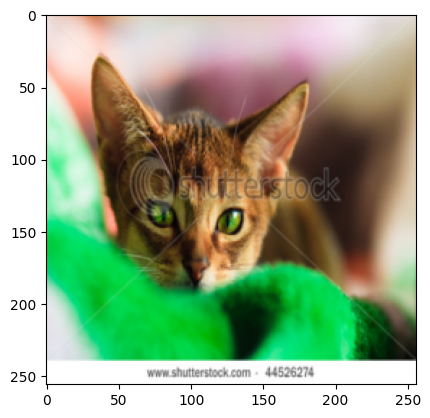

In [ ]:
plt.imshow(x['image'].astype(np.uint8).transpose(1, 2, 0))

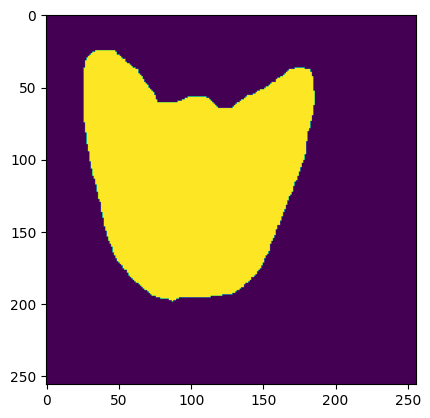

In [ ]:
plt.imshow(x['mask'].transpose(1, 2, 0))

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=1)

In [ ]:
for x in train_dataloader:
    break

In [ ]:
x['image'].shape, x['mask'].shape

(torch.Size([1, 3, 256, 256]), torch.Size([1, 1, 256, 256]))

In [ ]:
(x['mask']>0.5).sum()

tensor(19149)

# FCN

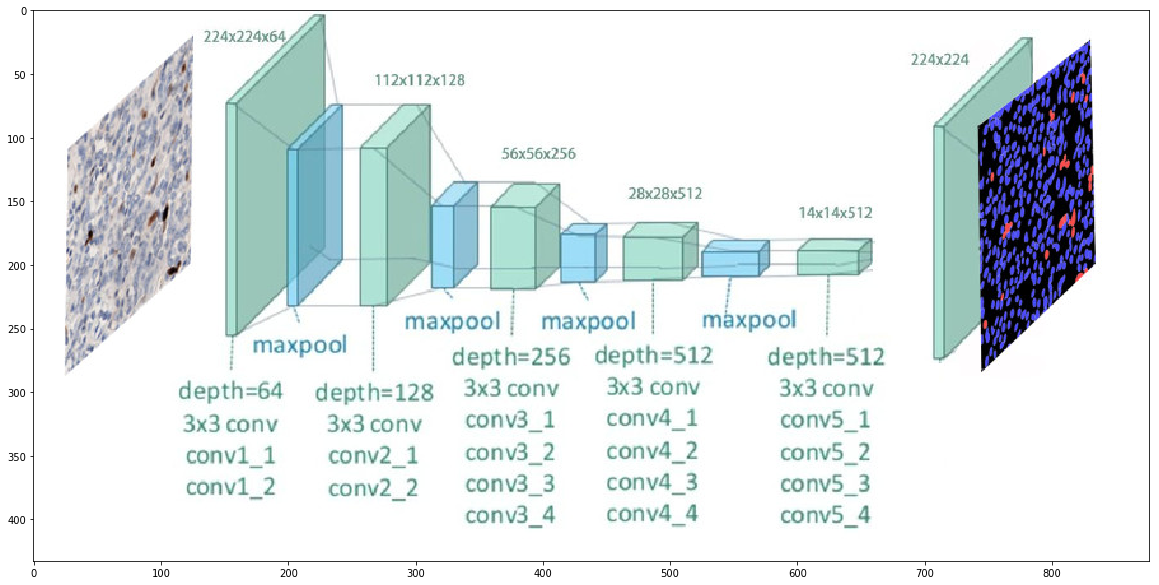

In [ ]:
fcn_png = cv2.imread('fcn.jpg')
plt.figure(figsize=(20,20))
plt.imshow(fcn_png[..., [2,1,0]])
plt.show()

In [ ]:
import torchvision.models as models

base_model = models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 177MB/s]


In [ ]:
base_model(x['image'].float()).size()

torch.Size([1, 1000])

In [ ]:
base_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
for param in base_model.parameters():
    if hasattr(param, 'requires_grad'):
        param.requires_grad = False

In [ ]:
base_model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [ ]:
base_features = nn.Sequential(base_model.features)

In [ ]:
base_features(x['image'].float()).size()

torch.Size([1, 512, 8, 8])

In [ ]:
list(base_model.classifier.children())[:-1]

[Linear(in_features=25088, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False)]

In [ ]:
nn.Sequential(*list(base_model.classifier.children())[:-1])

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
)

In [ ]:
nn.Linear(4096, 2)

Linear(in_features=4096, out_features=2, bias=True)

In [ ]:
256/8

32.0

In [ ]:
class SegNet(nn.Module):
    def __init__(self, features):
        super(SegNet, self).__init__()

        self.features = features
        self.pool = nn.AdaptiveAvgPool2d(output_size=(8, 8))
        self.up = nn.UpsamplingBilinear2d(scale_factor = 32)
        self.conv1 = nn.Conv2d(512, 1, (1, 1))

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = self.up(x)
        output = self.conv1(x)

        return output

In [ ]:
for param in base_features.parameters():
    if hasattr(param, 'requires_grad'):
        param.requires_grad = False

In [ ]:
model = SegNet(base_features)

In [ ]:
base_features(x['image'].float()).size()

torch.Size([1, 512, 8, 8])

In [ ]:
pred = model(x['image'].float())

In [ ]:
pred.shape

torch.Size([1, 1, 256, 256])

In [ ]:
pred = pred.detach().cpu().numpy()

In [ ]:
pred.shape

(1, 1, 256, 256)

In [ ]:
pred[0].transpose((1, 2, 0)).shape

(256, 256, 1)

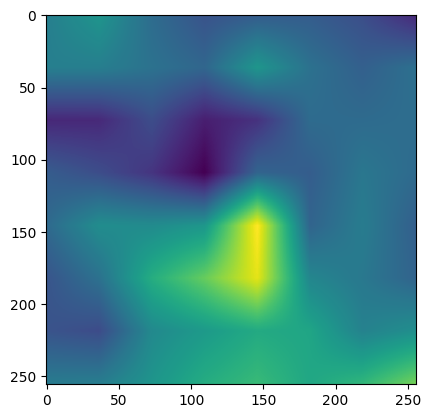

In [ ]:
plt.imshow(pred[0].transpose((1, 2, 0)))

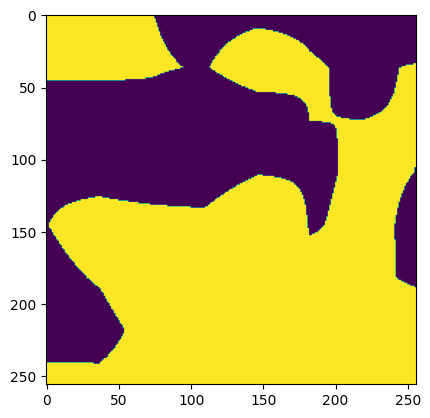

In [ ]:
plt.imshow((pred[0]>0).transpose((1, 2, 0)))

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=16, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=16, num_workers=2)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.BCEWithLogitsLoss()

device = 'cuda'

if torch.cuda.is_available():
    model.to(device)

In [ ]:
for epoch in range(5):
    model.train()
    train_loss_history = []
    for (batch_idx, data) in enumerate(train_dataloader):
        if torch.cuda.is_available():
            x = data['image'].to(device).float()
            y = data['mask'].to(device).float()

        optimizer.zero_grad()

        ypred = model(x)
        loss = criterion(ypred.float(),
                         y.float())

        train_loss_history.append(loss.item())

        loss.backward()

        optimizer.step()

    print(f"EPOCH {epoch}, Train Loss: {np.mean(train_loss_history)}")

    if test_dataloader is not None:
        test_loss_history = []
        model.eval()
        with torch.no_grad():
            for (batch_idx, data) in enumerate(test_dataloader):
                if torch.cuda.is_available():
                    x = data['image'].to(device).float()
                    y = data['mask'].to(device).float()

                ypred = model(x)
                loss = criterion(ypred, y)

                test_loss_history.append(loss.item())

    print(f"EPOCH {epoch}, Test Loss: {np.mean(test_loss_history)}")

EPOCH 0, Train Loss: 1.3950994345876906
EPOCH 0, Test Loss: 0.8190358462541
EPOCH 1, Train Loss: 0.6654621811880581
EPOCH 1, Test Loss: 0.5622714529866758
EPOCH 2, Train Loss: 0.522958349922429
EPOCH 2, Test Loss: 0.48513952636200447
EPOCH 3, Train Loss: 0.4784093376806969
EPOCH 3, Test Loss: 0.46124026308888977
EPOCH 4, Train Loss: 0.46316091997036035
EPOCH 4, Test Loss: 0.4540618805781655


In [ ]:
pred = model(x.float().to('cuda'))

In [ ]:
pred = pred.detach().cpu().numpy()

In [ ]:
np.unique(pred)

array([-12.613863 , -12.525306 , -12.436747 , ...,   5.9315233,
         5.939746 ,   5.947965 ], dtype=float32)

In [ ]:
x.shape

torch.Size([5, 3, 256, 256])

In [ ]:
pred.shape

(5, 1, 256, 256)

In [ ]:
x[0, :, :, :].shape

torch.Size([3, 256, 256])

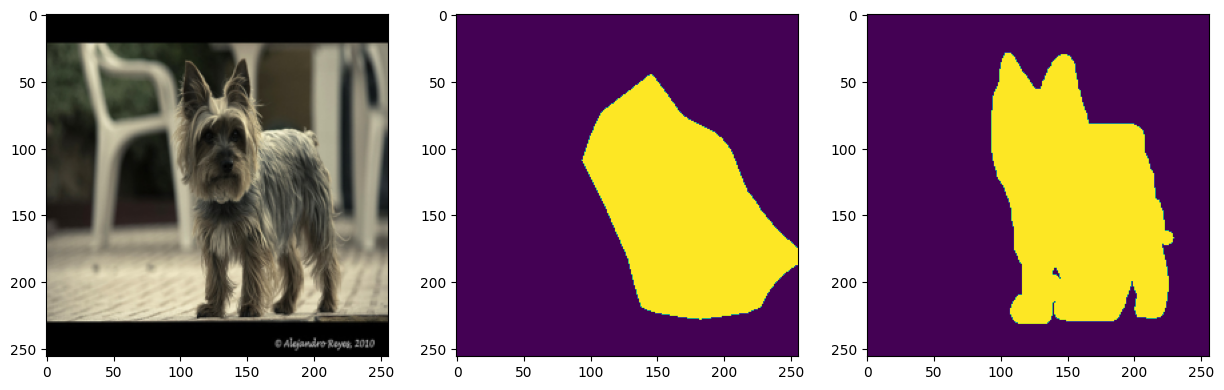

In [ ]:
im_id = 3
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
axes[0].imshow(x[im_id].detach().cpu().numpy().astype(int).transpose((1, 2, 0)))
axes[1].imshow((pred[im_id] > 0).transpose((1, 2, 0)).reshape(256, -1))
axes[2].imshow((y[im_id].detach().cpu().numpy()).transpose((1, 2, 0)).reshape(256, -1))

plt.show()

# SegNet

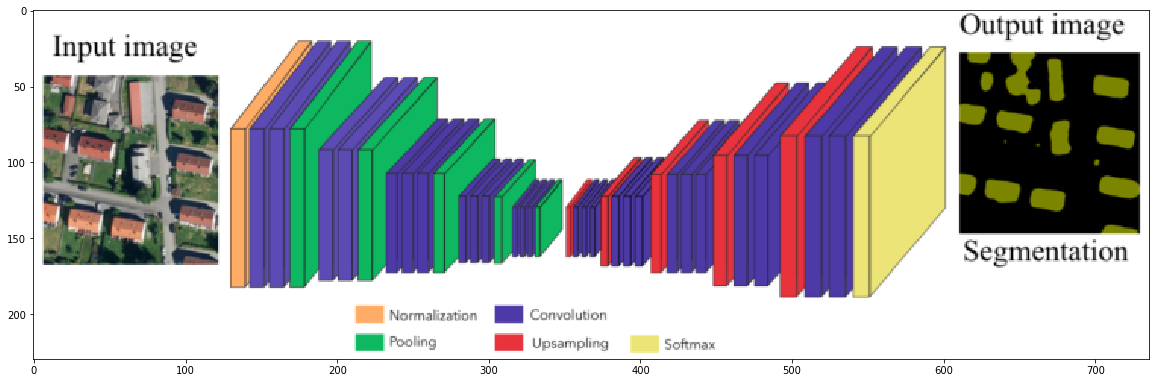

In [ ]:
seg_png = cv2.imread('segnet.png')
plt.figure(figsize=(20,20))
plt.imshow(seg_png[..., [2,1,0]])
plt.show()

In [ ]:
new_model = nn.Sequential(
    nn.Conv2d(3, 32, (3, 3), padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 32, (3, 3), padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(32, 64, (3, 3), padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 64, (3, 3), padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(64, 128, (3, 3), padding=1),
    nn.ReLU(),
    nn.Conv2d(128, 128, (3, 3), padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(128, 256, (3, 3), padding=1),
    nn.ReLU(),
    nn.Conv2d(256, 256, (3, 3), padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.UpsamplingBilinear2d(scale_factor=2),
    nn.Conv2d(256, 128, (3, 3), padding=1),
    nn.ReLU(),
    nn.Conv2d(128, 128, (3, 3), padding=1),
    nn.ReLU(),

    nn.UpsamplingBilinear2d(scale_factor=2),
    nn.Conv2d(128, 64, (3, 3), padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 64, (3, 3), padding=1),
    nn.ReLU(),

    nn.UpsamplingBilinear2d(scale_factor=2),
    nn.Conv2d(64, 32, (3, 3), padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 32, (3, 3), padding=1),
    nn.ReLU(),

    nn.UpsamplingBilinear2d(scale_factor=2),
    nn.Conv2d(32, 1, (3, 3), padding=1),
    nn.ReLU(),
    nn.Conv2d(1, 1, (3, 3), padding=1),
    )

In [ ]:
new_model(x.detach().cpu().float()).size()

torch.Size([5, 1, 256, 256])

In [ ]:
optimizer = torch.optim.Adam(new_model.parameters(), lr=3e-4)
criterion = nn.BCEWithLogitsLoss()

if torch.cuda.is_available():
    new_model.to('cuda')

In [ ]:
for epoch in range(5):
    model.train()
    train_loss_history = []
    for (batch_idx, data) in enumerate(train_dataloader):
        if torch.cuda.is_available():
            x = data['image'].to(device).float()
            y = data['mask'].to(device).float()

        optimizer.zero_grad()

        ypred = new_model(x)
        loss = criterion(ypred.float(),
                         y.float())

        train_loss_history.append(loss.item())

        loss.backward()

        optimizer.step()

    print(f"EPOCH {epoch}, Train Loss: {np.mean(train_loss_history)}")

    if test_dataloader is not None:
        test_loss_history = []
        model.eval()
        with torch.no_grad():
            for (batch_idx, data) in enumerate(test_dataloader):
                if torch.cuda.is_available():
                    x = data['image'].to(device).float()
                    y = data['mask'].to(device).float()

                ypred = new_model(x)
                loss = criterion(ypred, y)

                test_loss_history.append(loss.item())

    print(f"EPOCH {epoch}, Test Loss: {np.mean(test_loss_history)}")

EPOCH 0, Train Loss: 0.6513504357153667
EPOCH 0, Test Loss: 0.6049081939717997
EPOCH 1, Train Loss: 0.6000375091165736
EPOCH 1, Test Loss: 0.635394280501034
EPOCH 2, Train Loss: 0.5810878497102986
EPOCH 2, Test Loss: 0.8284263529207395
EPOCH 3, Train Loss: 0.5955292150594186
EPOCH 3, Test Loss: 0.6072921029899432
EPOCH 4, Train Loss: 0.5462094587116426
EPOCH 4, Test Loss: 0.630558960204539


In [ ]:
pred = new_model(x.float().to('cuda'))

In [ ]:
pred = pred.detach().cpu().numpy()

In [ ]:
np.unique(pred)

array([-22.043848  , -22.036201  , -22.016254  , ...,   0.17839578,
         0.21009375,   0.30583435], dtype=float32)

In [ ]:
x.shape

torch.Size([5, 3, 256, 256])

In [ ]:
pred.shape

(5, 1, 256, 256)

In [ ]:
x[0, :, :, :].shape

torch.Size([3, 256, 256])

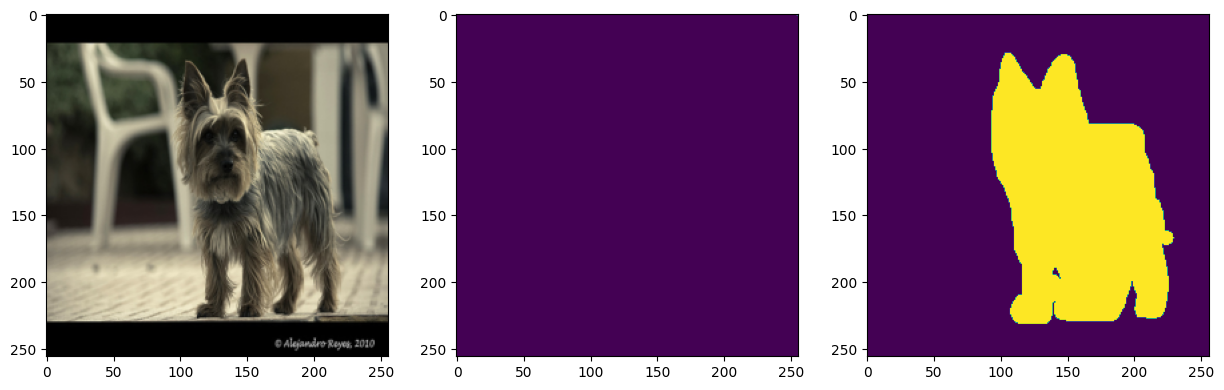

In [ ]:
im_id = 3
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
axes[0].imshow(x[im_id].detach().cpu().numpy().astype(int).transpose((1, 2, 0)))
axes[1].imshow((pred[im_id] > 0).transpose((1, 2, 0)).reshape(256, -1))
axes[2].imshow((y[im_id].detach().cpu().numpy()).transpose((1, 2, 0)).reshape(256, -1))

plt.show()

Как вы видите - нейронная сеть ведет себя крайне нестабильно.

### Задание 2 (0.6 балла)



1.   Диагностируйте проблему, почему нейронная сеть плохо справляется с поставленной задачей? Учитите, что нейросеть достаточно сложная, чтобы решить эту задачу. Посмотрите на поведение лосс функции.
2.   Модифицируйте архитектуру нейронной сети ниже, чтобы обучение стало стабильным.

*. За исследования поведения модели при выборе различных функций активации, аугментаций и т.д. так же предполагаются дополнительные баллы.

В данном блоке не нужно использовать segmentation-models-pytorch

In [ ]:
new_model_modified = nn.Sequential(
    nn.Conv2d(3, 32, (3, 3), padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 32, (3, 3), padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(32, 64, (3, 3), padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 64, (3, 3), padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(64, 128, (3, 3), padding=1),
    nn.ReLU(),
    nn.Conv2d(128, 128, (3, 3), padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(128, 256, (3, 3), padding=1),
    nn.ReLU(),
    nn.Conv2d(256, 256, (3, 3), padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.UpsamplingBilinear2d(scale_factor=2),
    nn.Conv2d(256, 128, (3, 3), padding=1),
    nn.ReLU(),
    nn.Conv2d(128, 128, (3, 3), padding=1),
    nn.ReLU(),

    nn.UpsamplingBilinear2d(scale_factor=2),
    nn.Conv2d(128, 64, (3, 3), padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 64, (3, 3), padding=1),
    nn.ReLU(),

    nn.UpsamplingBilinear2d(scale_factor=2),
    nn.Conv2d(64, 32, (3, 3), padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 32, (3, 3), padding=1),
    nn.ReLU(),

    nn.UpsamplingBilinear2d(scale_factor=2),
    nn.Conv2d(32, 1, (3, 3), padding=1),
    nn.ReLU(),
    nn.Conv2d(1, 1, (3, 3), padding=1),
    )

In [ ]:
optimizer = torch.optim.Adam(new_model_modified.parameters(), lr=3e-4)
criterion = nn.BCEWithLogitsLoss()

if torch.cuda.is_available():
    new_model_modified.to('cuda')

In [ ]:
for epoch in range(5):
    model.train()
    train_loss_history = []
    for (batch_idx, data) in enumerate(train_dataloader):
        if torch.cuda.is_available():
            x = data['image'].to(device).float()
            y = data['mask'].to(device).float()

        optimizer.zero_grad()

        ypred = new_model_modified(x)
        loss = criterion(ypred.float(),
                         y.float())

        train_loss_history.append(loss.item())

        loss.backward()

        optimizer.step()

    print(f"EPOCH {epoch}, Train Loss: {np.mean(train_loss_history)}")

    if test_dataloader is not None:
        test_loss_history = []
        model.eval()
        with torch.no_grad():
            for (batch_idx, data) in enumerate(test_dataloader):
                if torch.cuda.is_available():
                    x = data['image'].to(device).float()
                    y = data['mask'].to(device).float()

                ypred = new_model_modified(x)
                loss = criterion(ypred, y)

                test_loss_history.append(loss.item())

    print(f"EPOCH {epoch}, Test Loss: {np.mean(test_loss_history)}")

EPOCH 0, Train Loss: 0.6246995229076072
EPOCH 0, Test Loss: 0.5758078520712645
EPOCH 1, Train Loss: 0.5659159237635885
EPOCH 1, Test Loss: 0.5410332144602485
EPOCH 2, Train Loss: 0.5393969642655285
EPOCH 2, Test Loss: 0.5202267041672831
EPOCH 3, Train Loss: 0.5144316004094295
EPOCH 3, Test Loss: 0.4894767639429673
EPOCH 4, Train Loss: 0.48891714877552456
EPOCH 4, Test Loss: 0.4748302873062051


In [ ]:
np.unique(y.detach().cpu().numpy()), np.unique(x.detach().cpu().numpy())

(array([0., 1.], dtype=float32),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
         33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
         44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
         55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
         66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
         77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
         88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
         99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
        110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
        121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
        132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
     

In [ ]:
pred = new_model_modified(x.float().to('cuda'))

In [ ]:
pred = pred.detach().cpu().numpy()

In [ ]:
np.unique(pred)

array([-0.71279365, -0.7109832 , -0.70942116, ...,  6.2149425 ,
        6.216159  ,  6.219891  ], dtype=float32)

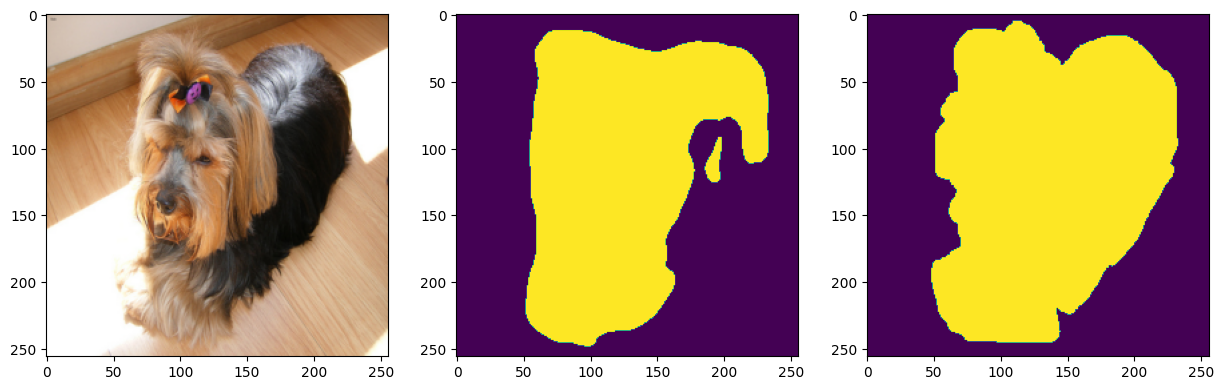

In [ ]:
im_id = 4
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
axes[0].imshow(x[im_id].detach().cpu().numpy().astype(int).transpose((1, 2, 0)))
axes[1].imshow(((pred[im_id])>0).transpose((1, 2, 0)).reshape(256, 256))
axes[2].imshow((y[im_id].detach().cpu().numpy()).transpose((1, 2, 0)).reshape(256, 256))

plt.show()

# Использование segmentation-models-pytorch для сегментации. Бонусная задача (0.3 балла)

# Vanilla Unet

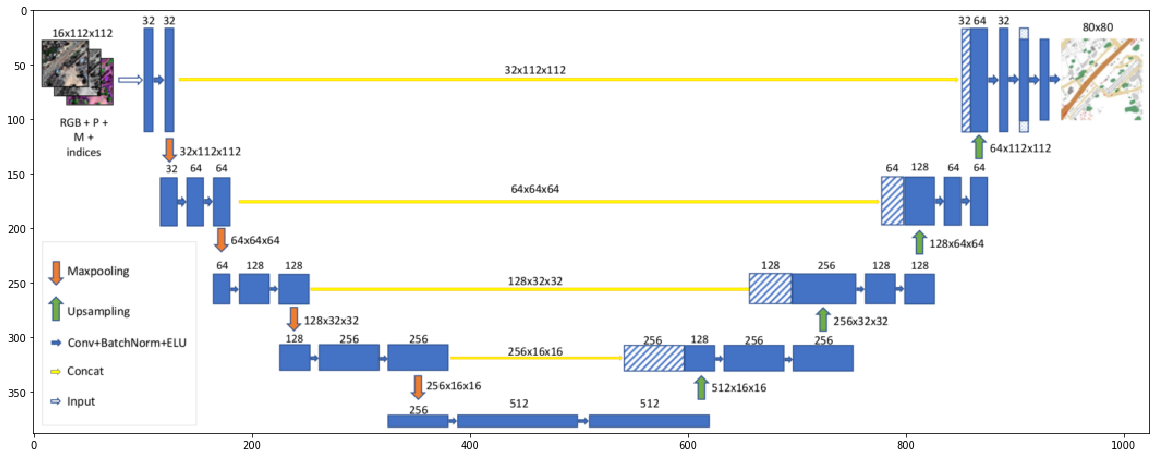

In [ ]:
seg_png = cv2.imread('unet.png')
plt.figure(figsize=(20,20))
plt.imshow(seg_png[..., [2,1,0]])
plt.show()

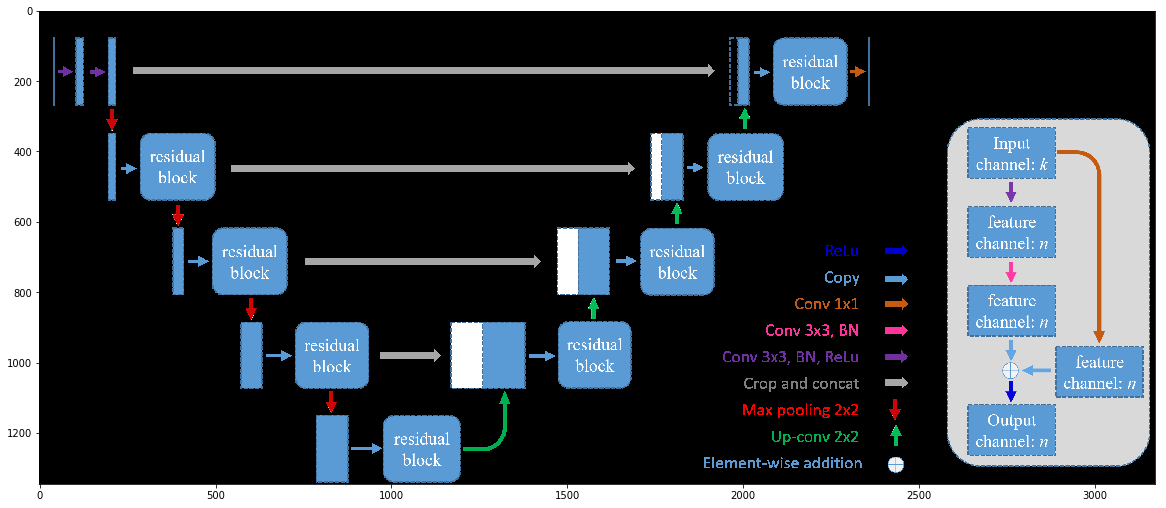

In [ ]:
seg_png = cv2.imread('unet_resnet_strucutre_new.png')
plt.figure(figsize=(20,20))
plt.imshow(seg_png[..., [2,1,0]])
plt.show()

In [ ]:
!pip install -U segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

Классической архитектурой для задачи сегментации является Unet:

In [ ]:
model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    decoder_use_batchnorm=True,
    in_channels=3,
    classes=1
)

In [ ]:
from segmentation_models_pytorch.losses import (
    DiceLoss,
    FocalLoss,
    MCCLoss,
    SoftBCEWithLogitsLoss,
)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = SoftBCEWithLogitsLoss()

if torch.cuda.is_available():
    model.to('cuda')

In [ ]:
for epoch in range(5):
    model.train()
    train_loss_history = []
    for (batch_idx, data) in enumerate(train_dataloader):
        if torch.cuda.is_available():
            x = data['image'].to(device).float()
            y = data['mask'].to(device).float()

        optimizer.zero_grad()

        ypred = model(x)
        loss = criterion(ypred.float(),
                         y.float())

        train_loss_history.append(loss.item())

        loss.backward()

        optimizer.step()

    print(f"EPOCH {epoch}, Train Loss: {np.mean(train_loss_history)}")

    if test_dataloader is not None:
        test_loss_history = []
        model.eval()
        with torch.no_grad():
            for (batch_idx, data) in enumerate(test_dataloader):
                if torch.cuda.is_available():
                    x = data['image'].to(device).float()
                    y = data['mask'].to(device).float()

                ypred = model(x)
                loss = criterion(ypred, y)

                test_loss_history.append(loss.item())

    print(f"EPOCH {epoch}, Test Loss: {np.mean(test_loss_history)}")

EPOCH 0, Train Loss: 0.26651940707135313
EPOCH 0, Test Loss: 0.19347272670787313
EPOCH 1, Train Loss: 0.16953801658850362
EPOCH 1, Test Loss: 0.15965827298553092
EPOCH 2, Train Loss: 0.13958617915277896
EPOCH 2, Test Loss: 0.16985091210707373
EPOCH 3, Train Loss: 0.1182609126691657
EPOCH 3, Test Loss: 0.15078416933184086
EPOCH 4, Train Loss: 0.11112830375775623
EPOCH 4, Test Loss: 0.16760589477160703


In [ ]:
pred = model(x.float().to('cuda'))

In [ ]:
pred = pred.detach().cpu().numpy()

In [ ]:
np.unique(pred)

array([-7.3271136, -7.3182473, -7.313011 , ..., 12.480305 , 12.504351 ,
       12.546463 ], dtype=float32)

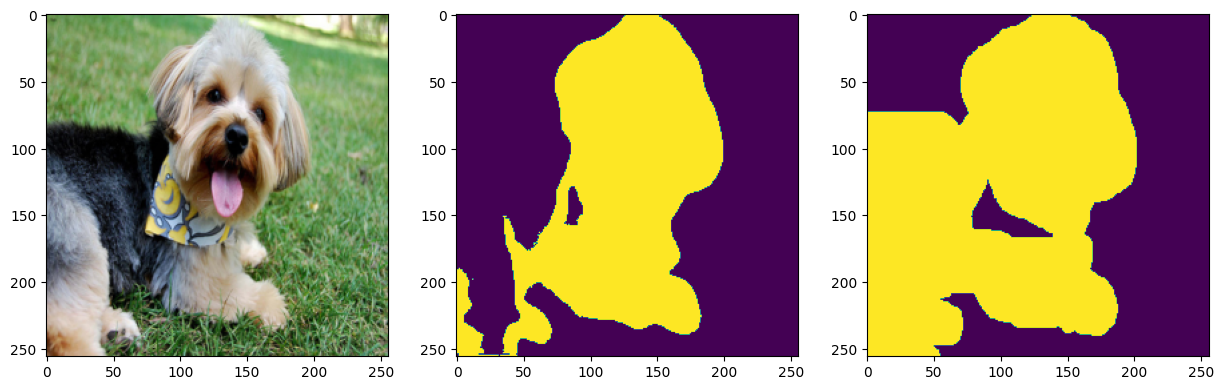

In [ ]:
im_id = 0
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
axes[0].imshow(x[im_id].detach().cpu().numpy().astype(int).transpose((1, 2, 0)))
axes[1].imshow(((pred[im_id])>0).transpose((1, 2, 0)).reshape(256, 256))
axes[2].imshow((y[im_id].detach().cpu().numpy()).transpose((1, 2, 0)).reshape(256, 256))

plt.show()

Задание:

*   Изучите документацию библиотеки segmentation-models-pytorch.
*   Попробуй перебрать различные архитектуры (Изменить комбинации энкодера и декодера)
*   Вы можете как поменять общую архитектуру (От Unet перейти к UnetPlusPlus/DeepLabV3), так и изменить энкодер (вместо resnet50 можно взять любой из timm!)
*   Так же вы можете добавить аттеншен в вашу нейронную сеть (scse attention)
*   Кроме этого можно изменить optimizer, добавить scheduler и т.д.

Цель - получить SoftBCEWithLogitsLoss на тестовой выборке меньше 0.1